In [2]:
!pip install spectral

import numpy as np
import keras
import spectral

#To load Hyperspectral image cube .mat file as input
import scipy
from scipy.io import loadmat


# To split training and testing data
import sklearn as sk
from sklearn.model_selection import train_test_split


# Principal Component Analysis 
from sklearn.decomposition import PCA

# Pipelining
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model, metrics
from sklearn.metrics import classification_report

from scipy.special import expit

from sklearn.preprocessing import normalize, MinMaxScaler, OneHotEncoder
from sklearn.utils import shuffle
from scipy.stats import truncnorm

from keras.utils import np_utils



In [3]:
!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

--2021-07-01 16:42:39--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   348KB/s    in 18s     

2021-07-01 16:42:58 (323 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2021-07-01 16:42:58--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2021-07-01 16:42:59 (102 MB/s) - ‘Indian_pines_gt.mat’ saved [1125/1125]

FINISHED --2021-07-01 16:42:59--
Total wall clock time: 20s
Downloaded: 2

In [4]:
!ls

Indian_pines_corrected.mat  Indian_pines_gt.mat  sample_data


In [5]:
def load_dataset():
    
    # X is the input dataset
    X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  
    # y is the labelled dataset
    y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

    print("Load dataset\n")
    
    X = (X-np.min(X))/(np.max(X)-np.min(X))
    
    # Print shape of input dataset (X) and labelled dataset (y)
    print(f"X shape : {X.shape}\ny shape : {y.shape}\n\n\n")
    
    return X,y

In [6]:
class PreProcessing:
    
    def __init__(self, X, y, pca_components, window_size):
        
        self.X = X
        self.y = y
        self.pca_components = pca_components
        self.window_size = window_size
        self.X_spectrum_vector = np.zeros((self.X.shape[0]*self.X.shape[1], self.X.shape[2],))
        self.X_pca = np.zeros((self.X.shape[0]*self.X.shape[1], pca_components))
        self.X_spatial_vector = np.zeros((self.X.shape[0]*self.X.shape[1], window_size*window_size*pca_components))
        
    
    
    def normalize_vectors(self,X):
        #return normalize(X)
        return (X-np.min(X))/(np.max(X)-np.min(X))
    
    
    def spectrum_vector(self):
        
        k=0
        
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[1]):
                X_spectrum = self.X[i,j,:]
                X_spectrum = X_spectrum.flatten()
                self.X_spectrum_vector[k,:] = X_spectrum
                k+=1
                
        #self.normalize_vectors(self.X_spectrum_vector)
        
        print(f"Spectrum vector shape : {self.X_spectrum_vector.shape}")
        
    
    def apply_pca(self):
  
        print("\n\nApply PCA\n")

        # Reshaping X from image dimensions to a list
        temp_X = np.reshape(self.X,(-1,self.X.shape[2]))
        print(f"temp_X shape : {temp_X.shape}")
  
        # Creating an objcect of class PCA with number of components 100
        pca = PCA(n_components = self.pca_components, whiten = True)
  
        # Applying and transforming dataset by PCA by removing the last column that is labelled column
        pca_X = pca.fit_transform(temp_X[:,:])

        # Reshaping new_X back to image dimensions with reduced number of bands
        self.X_pca = np.reshape(pca_X, (self.X.shape[0], self.X.shape[1], self.pca_components))
  
        print(f"X shape after applying PCA dimensionality reduction technique : {self.X_pca.shape}\n\n\n")
 
    
    def zero_padding_X(self, X, margin):

        # Creating a numpy 3D matrix of zeros with the required shape for zero padding
        zero_padded_X = np.zeros((X.shape[0]+2*margin, X.shape[1]+2*margin, X.shape[2]))

        # Offset is the starting address of hyperspectral image within zero_padded_X 
        offset = margin 

        # Copying the contents of X into zero_padded_x with correct offset address 
        zero_padded_X[offset:X.shape[0]+offset, offset:X.shape[1]+offset,:] = X

        print(f"The shape of X after zero padding : {zero_padded_X.shape}")

        return zero_padded_X
    
    def zero_padding_y(self, y, margin):

        # Creating a numpy 2D matrix of zeros with the required shape for zero padding
        zero_padded_y = np.zeros((y.shape[0]+2*margin, y.shape[1]+2*margin))

        # Offset is the starting address of hyperspectral image within zero_padded_X 
        offset = margin 

        # Copying the contents of X into zero_padded_x with correct offset address 
        zero_padded_y[offset:y.shape[0]+offset, offset:y.shape[1]+offset] = y

        print(f"The shape of y after zero padding : {zero_padded_y.shape}")
        #print(np.unique(zero_padded_y))
        return zero_padded_y
     
    
    def spatial_vector(self, labelling_type = "center"):

        X = self.X_pca
        y = self.y
        window_size = self.window_size 
        
        print("Create smaller image cuboids\n")
  
        stride = 1
  
        # Calculating the margin required for zero padding for a particular window size (or smaller cube size)
        zero_padding_margin = int((window_size - stride) / 2)
  
        # Applying zero padding to X
        zero_padded_X = self.zero_padding_X(X, zero_padding_margin)

        # Apply zero padding to y
        zero_padded_y = self.zero_padding_y(y, zero_padding_margin)

        # Create a matrix for assigning labels to smaller cuboids X_cuboids
        y_cuboids_labels = np.zeros((X.shape[0]*X.shape[1]))

        offset = zero_padding_margin

        # Traversing through X and y to split X and y accordingly
        index = 0
        for i in range(offset,zero_padded_X.shape[0]-offset):
            for j in range(offset, zero_padded_X.shape[1]-offset):

                # Extracting smaller cube from zero_padded_X
                cube = zero_padded_X[i-offset:i+offset+1,j-offset:j+offset+1]

                # Storing the extracted cube from zero_padded_X into X_cuboids
                self.X_spatial_vector[index,:] = cube.flatten() 

                # Storing the extracted matrix from zero_padded_y into y_labels
                y_labels = zero_padded_y[i-offset:i+offset+1,j-offset:j+offset+1]
        
        
                if labelling_type=="majority":
          
                    # Calculating mode of y_labels matrix
                    y_label = mode(y_labels, axis=None, nan_policy="omit")
          
                    # Assigning label to a particular index's X_cuboid
                    y_cuboids_labels[index] = int(y_label[0])

                elif labelling_type=="center":

                    y_label = y_labels[y_labels.shape[0]//2,y_labels.shape[1]//2]
                    y_cuboids_labels[index] = int(y_label)

                #print(y_label)                
                
                index+=1   
                  
        self.y = y_cuboids_labels.flatten()
        
        self.normalize_vectors(self.X_spatial_vector)
        
        #scaler = MinMaxScaler(copy=True)
        #caler.fit_transform(X_spatial_vector)

        
        print(f"\n\nSpatial vector shape : {self.X_spatial_vector.shape}")
        print(f"The shape of y_cuboids_labels : {y_cuboids_labels.shape}\n\n\n")


    def remove_class_zero(self):

        
        print("\n\nRemoving class zero\n")
        
        self.X_spatial_vector = self.X_spatial_vector[self.y>0,:]
        self.X_spectrum_vector = self.X_spectrum_vector[self.y>0,:]
        self.y = self.y[self.y>0]
        print(f"Classes available for classification after removing class 0 : {np.unique(self.y)}")
        self.y -= 1 
        print(f"New Class labels starting from 0 :  {np.unique(self.y)}")
            
        
        print(f"\n\nSpectrum vector shape after removing class zero: {self.X_spectrum_vector.shape}")
        print(f"\n\nSpatial vector shape after removing class zero: {self.X_spatial_vector.shape}")
        print(f"The shape of y after removing class zero : {self.y.shape}\n\n\n")
    
    
    def remove_tiny_class(self):

        
        print("\n\nRemoving tiny classes\n")

        unique, counts = np.unique(self.y, return_counts=True)
        elements=dict(zip(unique, counts))
        print(f"Number of elements present in each class of {'y'}: {elements}")
        #print(unique)

        y_temp = np.zeros(len(unique))
        i=0
        y1 = self.y.flatten()
        for i in y1:
          if y_temp[int(i)]==1:
            continue
          elif elements[i] > 500:
            y_temp[int(i)] = 0
          else: y_temp[int(i)] = 1

        j=0
        zero_count=0
        lst=[]
        y_labels = np.zeros(len(unique))
        for j in range(len(y_temp)):
          if int(y_temp[j])==1:
            lst.append(unique[j])
            y_labels[j] = j - zero_count
          elif int(y_temp[j])==0:
            zero_count += 1
          j += 1  
        y_labels = np.unique(y_labels)  

        k=0
        for k in range(17):
          if k in lst:
            self.X_spatial_vector = self.X_spatial_vector[self.y!=k,:]
            self.X_spectrum_vector = self.X_spectrum_vector[self.y!=k,:]
            self.y = self.y[self.y!=k]


        d, indices = np.unique(self.y, return_inverse = True)
        print(d)
        print(indices)
        self.y = indices
        #self.y = y_labels
        #c=0
        #for n in range(len(np.unique(self.y))):
          #if self.y[self.y]==n:
          #self.y[self.y==n] = y_labels[n]
          #self.y = np.where(self.y[self.y==n], y_labels[n], self.y)
            #c += 1


        print(f"Classes available for classification after removing tiny classes : {np.unique(self.y)}")
            
        
        print(f"\n\nSpectrum vector shape after removing tiny classes: {self.X_spectrum_vector.shape}")
        print(f"\n\nSpatial vector shape after removing tiny classes: {self.X_spatial_vector.shape}")
        print(f"The shape of y after removing tiny classes : {self.y.shape}\n\n\n")

  
    def combine_vectors(self):
        
        self.X = np.hstack((self.X_spectrum_vector, self.X_spatial_vector))
        self.y = self.y.flatten()
        
        print(f"Combined final vector shape : {self.X.shape}")
        print(f"y shape : {self.y.shape}")

        return self.X, self.y
    
    def count_frequency(self, y, name):
        
        unique, counts = np.unique(y, return_counts=True)
        elements=dict(zip(unique, counts))
        print(f"Number of elements present in each class of {name}: {elements}")      
    
    def split_dataset(self, training_size = 500):
        
        
        
        #one_hot_encoder = OneHotEncoder(sparse=False)
        #one_hot_encoder.fit_transform(self.y)
        
        #self.y = np_utils.to_categorical(self.y)
        
        print("\n\nSplitting Dataset\n" )
        
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y,
                                                            train_size=0.6,
                                                            random_state=10,
                                                            shuffle=True,
                                                            stratify=self.y)
        self.count_frequency(self.y, name="y")            
             
      
        
        # Print shapes of training and testing datasets
        print(f"X_train shape : {X_train.shape}")
        print(f"y_train shape : {y_train.shape}")
        print(f"X_test shape  : {X_test.shape}")
        print(f"y_test shape  : {y_test.shape}")
        
        self.count_frequency(y_train, name="y_train")
        self.count_frequency(y_test, name="y_test")
        
        return (X_train, X_test, y_train, y_test)
    
        
        
        
    

In [7]:
class BinaryRBM:
    """
    This class implements a Binary Restricted Boltzmann machine.
    """

    def __init__(self,
                 n_hidden_units=100,
                 activation_function='sigmoid',
                 optimization_algorithm='sgd',
                 learning_rate=1e-3,
                 n_epochs=10,
                 contrastive_divergence_iter=1,
                 batch_size=32,
                 verbose=True):
        self.n_hidden_units = n_hidden_units
        self.activation_function = activation_function
        self.optimization_algorithm = optimization_algorithm
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.contrastive_divergence_iter = contrastive_divergence_iter
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X):
        """
        Fit a model given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        # Initialize RBM parameters
        self.n_visible_units = X.shape[1]
        if self.activation_function == 'sigmoid':
            self.W = np.random.randn(self.n_hidden_units, self.n_visible_units) / np.sqrt(self.n_visible_units)
            self.c = np.random.randn(self.n_hidden_units) / np.sqrt(self.n_visible_units)
            self.b = np.random.randn(self.n_visible_units) / np.sqrt(self.n_visible_units)
            self._activation_function_class = SigmoidActivationFunction
        elif self.activation_function == 'relu':
            self.W = truncnorm.rvs(-0.2, 0.2, size=[self.n_hidden_units, self.n_visible_units]) / np.sqrt(
                self.n_visible_units)
            self.c = np.full(self.n_hidden_units, 0.1) / np.sqrt(self.n_visible_units)
            self.b = np.full(self.n_visible_units, 0.1) / np.sqrt(self.n_visible_units)
            self._activation_function_class = ReLUActivationFunction
        else:
            raise ValueError("Invalid activation function.")

        if self.optimization_algorithm == 'sgd':
            self._stochastic_gradient_descent(X)
        else:
            raise ValueError("Invalid optimization algorithm.")
        return self

    def transform(self, X):
        """
        Transforms data using the fitted model.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        if len(X.shape) == 1:  # It is a single sample
            return self._compute_hidden_units(X)
        transformed_data = self._compute_hidden_units_matrix(X)
        return transformed_data

    def _reconstruct(self, transformed_data):
        """
        Reconstruct visible units given the hidden layer output.
        :param transformed_data: array-like, shape = (n_samples, n_features)
        :return:
        """
        return self._compute_visible_units_matrix(transformed_data)

    
    def batch_generator(self, batch_size, data, labels=None):
        """
        Generates batches of samples
        :param data: array-like, shape = (n_samples, n_features)
        :param labels: array-like, shape = (n_samples, )
        :return:
        """
        n_batches = int(np.ceil(len(data) / float(batch_size)))
        idx = np.random.permutation(len(data))
        data_shuffled = data[idx]
        if labels is not None:
            labels_shuffled = labels[idx]
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            if labels is not None:
                yield data_shuffled[start:end, :], labels_shuffled[start:end]
            else:
                yield data_shuffled[start:end, :]
  
    def _stochastic_gradient_descent(self, _data):
        """
        Performs stochastic gradient descend optimization algorithm.
        :param _data: array-like, shape = (n_samples, n_features)
        :return:
        """
        accum_delta_W = np.zeros(self.W.shape)
        accum_delta_b = np.zeros(self.b.shape)
        accum_delta_c = np.zeros(self.c.shape)
        for iteration in range(1, self.n_epochs + 1):
            idx = np.random.permutation(len(_data))
            data = _data[idx]
            for batch in self.batch_generator(self.batch_size, data):
                accum_delta_W[:] = .0
                accum_delta_b[:] = .0
                accum_delta_c[:] = .0
                for sample in batch:
                    delta_W, delta_b, delta_c = self._contrastive_divergence(sample)
                    accum_delta_W += delta_W
                    accum_delta_b += delta_b
                    accum_delta_c += delta_c
                self.W += self.learning_rate * (accum_delta_W / self.batch_size)
                self.b += self.learning_rate * (accum_delta_b / self.batch_size)
                self.c += self.learning_rate * (accum_delta_c / self.batch_size)
            if self.verbose:
                error = self._compute_reconstruction_error(data)
                print(">> Epoch %d finished \tRBM Reconstruction error %f" % (iteration, error))

    def _contrastive_divergence(self, vector_visible_units):
        """
        Computes gradients using Contrastive Divergence method.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v_0 = vector_visible_units
        v_t = np.array(v_0)

        # Sampling
        for t in range(self.contrastive_divergence_iter):
            h_t = self._sample_hidden_units(v_t)
            v_t = self._compute_visible_units(h_t)

        # Computing deltas
        v_k = v_t
        h_0 = self._compute_hidden_units(v_0)
        h_k = self._compute_hidden_units(v_k)
        delta_W = np.outer(h_0, v_0) - np.outer(h_k, v_k)
        delta_b = v_0 - v_k
        delta_c = h_0 - h_k

        return delta_W, delta_b, delta_c

    def _sample_hidden_units(self, vector_visible_units):
        """
        Computes hidden unit activations by sampling from a binomial distribution.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        hidden_units = self._compute_hidden_units(vector_visible_units)
        return (np.random.random_sample(len(hidden_units)) < hidden_units).astype(np.int64)

    def _sample_visible_units(self, vector_hidden_units):
        """
        Computes visible unit activations by sampling from a binomial distribution.
        :param vector_hidden_units: array-like, shape = (n_features, )
        :return:
        """
        visible_units = self._compute_visible_units(vector_hidden_units)
        return (np.random.random_sample(len(visible_units)) < visible_units).astype(np.int64)

    def _compute_hidden_units(self, vector_visible_units):
        """
        Computes hidden unit outputs.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = np.expand_dims(vector_visible_units, 0)
        h = np.squeeze(self._compute_hidden_units_matrix(v))
        return np.array([h]) if not h.shape else h

    def _compute_hidden_units_matrix(self, matrix_visible_units):
        """
        Computes hidden unit outputs.
        :param matrix_visible_units: array-like, shape = (n_samples, n_features)
        :return:
        """
        return np.transpose(self._activation_function_class.function(
            np.dot(self.W, np.transpose(matrix_visible_units)) + self.c[:, np.newaxis]))

    def _compute_visible_units(self, vector_hidden_units):
        """
        Computes visible (or input) unit outputs.
        :param vector_hidden_units: array-like, shape = (n_features, )
        :return:
        """
        h = np.expand_dims(vector_hidden_units, 0)
        v = np.squeeze(self._compute_visible_units_matrix(h))
        return np.array([v]) if not v.shape else v

    def _compute_visible_units_matrix(self, matrix_hidden_units):
        """
        Computes visible (or input) unit outputs.
        :param matrix_hidden_units: array-like, shape = (n_samples, n_features)
        :return:
        """
        return self._activation_function_class.function(np.dot(matrix_hidden_units, self.W) + self.b[np.newaxis, :])

    def _compute_free_energy(self, vector_visible_units):
        """
        Computes the RBM free energy.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = vector_visible_units
        return - np.dot(self.b, v) - np.sum(np.log(1 + np.exp(np.dot(self.W, v) + self.c)))

    def _compute_reconstruction_error(self, data):
        """
        Computes the reconstruction error of the data.
        :param data: array-like, shape = (n_samples, n_features)
        :return:
        """
        data_transformed = self.transform(data)
        data_reconstructed = self._reconstruct(data_transformed)
        return np.mean(np.sum((data_reconstructed - data) ** 2, 1))

In [8]:
class UnsupervisedDBN:
    """
    This class implements a unsupervised Deep Belief Network.
    """

    def __init__(self,
                 hidden_layers_structure=[100, 100],
                 activation_function='sigmoid',
                 optimization_algorithm='sgd',
                 learning_rate_rbm=1e-3,
                 n_epochs_rbm=10,
                 contrastive_divergence_iter=1,
                 batch_size=32,
                 verbose=True):
        self.hidden_layers_structure = hidden_layers_structure
        self.activation_function = activation_function
        self.optimization_algorithm = optimization_algorithm
        self.learning_rate_rbm = learning_rate_rbm
        self.n_epochs_rbm = n_epochs_rbm
        self.contrastive_divergence_iter = contrastive_divergence_iter
        self.batch_size = batch_size
        self.rbm_layers = None
        self.verbose = verbose
        self.rbm_class = BinaryRBM

    def fit(self, X, y=None):
        """
        Fits a model given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        # Initialize rbm layers
        self.rbm_layers = list()
        for n_hidden_units in self.hidden_layers_structure:
            rbm = self.rbm_class(n_hidden_units=n_hidden_units,
                                 activation_function=self.activation_function,
                                 optimization_algorithm=self.optimization_algorithm,
                                 learning_rate=self.learning_rate_rbm,
                                 n_epochs=self.n_epochs_rbm,
                                 contrastive_divergence_iter=self.contrastive_divergence_iter,
                                 batch_size=self.batch_size,
                                 verbose=self.verbose)
            self.rbm_layers.append(rbm)

        # Fit RBM
        if self.verbose:
            print("[START] Pre-training step:")
        input_data = X
        for rbm in self.rbm_layers:
            rbm.fit(input_data)
            input_data = rbm.transform(input_data)
        if self.verbose:
            print("[END] Pre-training step")
        return self

    def transform(self, X):
        """
        Transforms data using the fitted model.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        input_data = X
        for rbm in self.rbm_layers:
            input_data = rbm.transform(input_data)
        return input_data


In [9]:
class SigmoidActivationFunction:
    @classmethod
    def function(cls, x):
        """
        Sigmoid function.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return expit(x)

    @classmethod
    def prime(cls, x):
        """
        Compute sigmoid first derivative.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return x * (1 - x)

In [10]:
class ReLUActivationFunction:
    @classmethod
    def function(cls, x):
        """
        Rectified linear function.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return np.maximum(np.zeros(x.shape), x)

    @classmethod
    def prime(cls, x):
        """
        Rectified linear first derivative.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return (x > 0).astype(int)


In [11]:
if __name__ == '__main__':
    
    X, y = load_dataset()
    
    prep = PreProcessing(X , y, pca_components = 10, window_size = 3)
    
    prep.spectrum_vector()
    
    prep.apply_pca()
    
    prep.spatial_vector()
    
    prep.remove_class_zero()

    prep.remove_tiny_class()
    
    prep.combine_vectors()
    
    X_train, X_test, y_train, y_test = prep.split_dataset() 
    
     #Models we will use
    logistic = linear_model.LogisticRegression(multi_class='multinomial')
    dbn = UnsupervisedDBN(hidden_layers_structure=[90, 50, 50],
                          batch_size=10,
                          learning_rate_rbm=0.01,
                          n_epochs_rbm=40,
                          activation_function='sigmoid')

    classifier = Pipeline(steps=[('dbn', dbn),
                             ('logistic', logistic)])


     #Training
    #logistic.C = 6000.0

     #Training RBM-Logistic Pipeline
    classifier.fit(X_train, y_train)

     #Training Logistic regression
    #logistic_classifier = linear_model.LogisticRegression(C=100.0)
    #logistic_classifier.fit(X_train, y_train)


    
    #Evaluation

    print()
    print("Logistic regression using RBM features:\n%s\n" % (classification_report(y_train,
                                                                                   classifier.predict(X_train))))

    print("Logistic regression using raw pixel features:\n%s\n" % (classification_report(y_test,
                                                                                         classifier.predict(X_test))))


Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Spectrum vector shape : (21025, 200)


Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 10)



Create smaller image cuboids

The shape of X after zero padding : (147, 147, 10)
The shape of y after zero padding : (147, 147)


Spatial vector shape : (21025, 90)
The shape of y_cuboids_labels : (21025,)





Removing class zero

Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


Spectrum vector shape after removing class zero: (10249, 200)


Spatial vector shape after removing class zero: (10249, 90)
The shape of y after removing class zero : (10249,)





Removing tiny classes

Number of elements present in each class of y: {0.0: 46, 1.0: 1428, 2.0: 830, 3.0: 237, 4.0: 483, 5.0: 730, 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

In [ ]:
# Load the original dataset
X, y = load_dataset()

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)





In [ ]:
prep = PreProcessing(X , y, pca_components = 3, window_size = 3)

In [ ]:
prep.apply_pca()



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 3)





In [ ]:
prep.spatial_vector()
    
X_comb,y_comb = prep.combine_vectors()

print(X.shape)
print(y.shape)

Create smaller image cuboids

The shape of X after zero padding : (147, 147, 3)
The shape of y after zero padding : (147, 147)


Spatial vector shape : (21025, 27)
The shape of y_cuboids_labels : (21025,)



Combined final vector shape : (21025, 227)
y shape : (21025,)
(145, 145, 200)
(145, 145)


In [ ]:
height = y.shape[0]
width = y.shape[1]

In [ ]:
# calculate the predicted image
from tqdm.auto import trange

predicted_output = np.zeros((height,width))
#X = np.reshape(X_comb,(X.shape[0], X.shape[1], X_comb.shape[1]))

#start = time.time()
count = 0
for i in trange(height, desc="Predicting image"):
    #for j in trange(width,leave=False):
    for j in range(width):
      target = int(y[i,j])
      if target == 0 :
          continue
      else :
          #image_patch=Patch(X,i,j,window_size=3)
          #print(f"image_patch shape : {image_patch.shape}")
          #X_test_image = image_patch.reshape(image_patch.shape[0]*image_patch.shape[1], image_patch.shape[2]).astype('float32')                                  
          vector = X_comb[count, :].reshape(1, -1)
          prediction = (classifier.predict(vector))
          #print(prediction)
          #prediction = np.argmax(prediction, axis=0)
          predicted_output[i][j] = prediction+1
          count += 1

#end = time.time()
#testing_time = end - start
#print(f"Time taken for predicting entire image : {str(timedelta(seconds=testing_time))}\n\n\n")

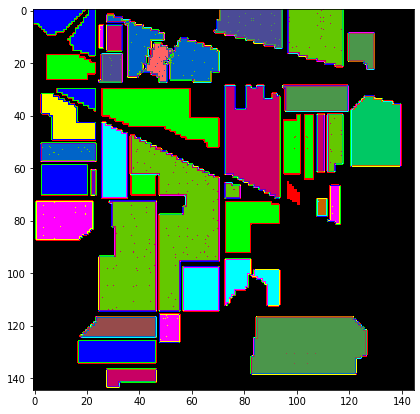

In [ ]:
# Display groundtruth image
ground_truth=spectral.imshow(classes=y,figsize=(7,7))

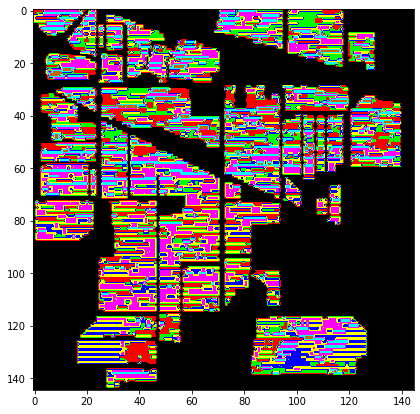

In [ ]:
# Display predicted image
predict_image = spectral.imshow(classes = predicted_output.astype(int),figsize =(7,7))